In [1]:
from glob import glob
import os
import numpy as np
import torch
from typing import List, Union, Tuple, Optional, Callable
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [2]:
input_dir = "/home/nbaranov/projects/04_cv/MedicalImageAnalysis/data/small_data/small/"
f_size = (14,8)

t1_dir = os.path.join(input_dir, 't1')
t2_dir = os.path.join(input_dir, 't2')

1.  Create a function that takes a tuple of two images and returns a tuple of the same two cropped (or, equivalently, a patch from the) images, where the cropped images are of the same randomly determined location.

2.  Verify that this was implemented correctly by visualizing the output images as in the previous module.
Create a class that inherits from Dataset to handle the NIfTI files.

In [3]:
def glob_imgs(path: str, ext='*.nii*') -> List[str]:
    """
    Grab all `ext` files in a directory and sort them for consistency
    """
    fns = sorted(glob(os.path.join(path, ext)))
    return fns


class NiftiDataset(Dataset):
    """
    Create a dataset class in PyTorch for reading NIfTI files

    Args:
        source_dir (str): path to source images
        target_dir (str): path to target images
        transform (Callable): transform to apply to both source and target images
        preload (bool): load all data when initializing the dataset
    """

    def __init__(self, source_dir: str,
                 target_dir: str,
                 transform: Optional[Callable]=None,
                 preload: bool=True
                 ):
        self.source_dir, self.target_dir = source_dir, target_dir
        self.source_fns, self.target_fns = glob_imgs(source_dir), glob_imgs(target_dir)
        self.transform = transform
        self.preload = preload
        if len(self.source_fns) != len(self.target_fns) or len(self.source_fns) == 0:
            raise ValueError(f'Number of source and target images must be equal and non-zero')
        if preload:
            self.imgs = [(nib.load(s).get_fdata().astype(np.float32),
                          nib.load(t).get_fdata().astype(np.float32))
                         for s, t in zip(self.source_fns, self.target_fns)]

    def __len__(self):
        return len(self.source_fns)

    def __getitem__(self, idx:int):
        if not self.preload:
            src_fn, tgt_fn = self.source_fns[idx], self.target_fns[idx]
            sample = (nib.load(src_fn).get_fdata(), nib.load(tgt_fn).get_fdata())
        else:
            sample = self.imgs[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [4]:
ds = NiftiDataset(source_dir=t1_dir,
                  target_dir=t2_dir,
                  preload=False,
                  )

In [5]:
ds.__len__()

28

In [14]:
img1, img2 = ds.__getitem__(0)
assert img1.shape == img2.shape and img1.shape != 0
print(img1.shape)

(120, 120, 90)


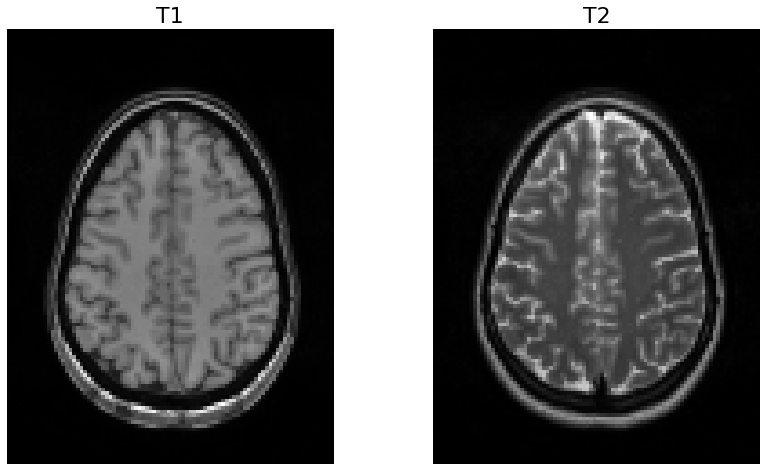

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=f_size)
ax1.imshow(img1[:,90,:], cmap='gray')
ax1.set_title('T1', fontsize=22)
ax1.axis('off')

ax2.imshow(img2[:,90,:], cmap='gray')
ax2.set_title('T2', fontsize=22)
ax2.axis('off');

In [8]:
class BaseTransform:
    def __repr__(self):
        return f'{self.__class__.__name__}'


class ToTensor(BaseTransform):
    """
    Convert images in sample to torch.Tensors
    """
    def __call__(self, sample: Tuple[np.ndarray,np.ndarray]) -> Tuple[torch.Tensor,torch.Tensor]:
        src, tgt = sample
        return torch.from_numpy(src), torch.from_numpy(tgt)


class CropBase(BaseTransform):
    """
    Base class for crop transform
    """
    def __init__(self, out_dim: int, output_size: Union[tuple,int,list], threshold: Optional[float]=None):
        """
        Provide the common functionality for RandomCrop2D and RandomCrop3D
        """
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = (output_size,)
            for _ in range(out_dim - 1):
                self.output_size += (output_size,)
        else:
            assert len(output_size) == out_dim
            self.output_size = output_size
        self.out_dim = out_dim
        self.thresh = threshold

    def _get_sample_idxs(self, img: np.ndarray) -> Tuple[int,int,int]:
        """
        Get the set of indices from which to sample (foreground)
        """
        mask = np.where(img >= (img.mean() if self.thresh is None else self.thresh))  # returns a tuple of length 3
        c = np.random.randint(0, len(mask[0]))  # choose the set of idxs to use
        h, w, d = [m[c] for m in mask]  # pull out the chosen idxs
        return h, w, d

    def __repr__(self):
        s = '{name}(output_size={output_size}, threshold={thresh})'
        d = dict(self.__dict__)
        return s.format(name=self.__class__.__name__, **d)


class RandomCrop3D(CropBase):
    """
    Randomly crop a 3d patch from a (pair of) 3d image

    Args:
        output_size (tuple or int): Desired output size.
            If int, cube crop is made.
    """

    def __init__(self, output_size: Union[tuple,int,list], threshold: Optional[float]=None):
        super().__init__(3, output_size, threshold)

    def __call__(self, sample: Tuple[np.ndarray,np.ndarray]) -> Tuple[np.ndarray,np.ndarray]:
        src, tgt = sample
        *cs, h, w, d = src.shape
        *ct, _, _, _ = tgt.shape
        hh, ww, dd = self.output_size
        max_idxs = (h - hh//2, w - ww//2, d - dd//2)
        min_idxs = (hh//2, ww//2, dd//2)
        s = src[0] if len(cs) > 0 else src  # use the first image to determine sampling if multimodal
        s_idxs = super()._get_sample_idxs(s)
        i, j, k = [i if min_i <= i <= max_i else max_i if i > max_i else min_i
                   for max_i, min_i, i in zip(max_idxs, min_idxs, s_idxs)]
        oh = 0 if hh % 2 == 0 else 1
        ow = 0 if ww % 2 == 0 else 1
        od = 0 if dd % 2 == 0 else 1
        s = src[..., i - hh//2: i + hh//2 + oh, j - ww//2: j + ww//2 + ow, k - dd//2: k + dd//2 + od]
        t = tgt[..., i - hh//2: i + hh//2 + oh, j - ww//2: j + ww//2 + ow, k - dd//2: k + dd//2 + od]
        if len(cs) == 0: s = s[np.newaxis,...]  # add channel axis if empty
        if len(ct) == 0: t = t[np.newaxis,...]
        return s, t


# class RandomCrop3D:
#     def __init__(self, output_size: int):
#         self.output_size = output_size
#
#     def __call__(self, sample, target):
#         return self.random_crop(sample, target)
#
#     def random_crop(self, sample, target):
#         start_idx = np.random.randint(0, sample.shape[0] - self.output_size + 1)
#
#         sample = sample[start_idx: start_idx + self.output_size,
#                               start_idx: start_idx + self.output_size, :]
#         target = target[start_idx: start_idx + self.output_size,
#                   start_idx: start_idx + self.output_size, :]
#
#         # sample = np.moveaxis(sample, 2, 0)
#         # target = np.moveaxis(target, 2, 0)
#
#         return sample, target

In [9]:
random_crop = RandomCrop3D(output_size=(32, 32, 90))

In [10]:
random_crop.__repr__()

'RandomCrop3D(output_size=(32, 32, 90), threshold=None)'

(1, 32, 32, 90)


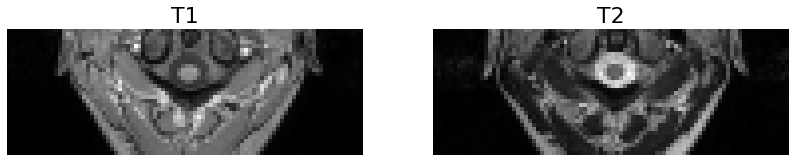

In [40]:
t1_crop, t2_crop = random_crop((img1, img2))
assert t1_crop.shape == t2_crop.shape and t1_crop.shape != 0
print(t1_crop.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=f_size)
ax1.imshow(t1_crop[0][:,15,:], cmap='gray')
ax1.set_title('T1', fontsize=22)
ax1.axis('off')

ax2.imshow(t2_crop[0][:,15,:], cmap='gray')
ax2.set_title('T2', fontsize=22)
ax2.axis('off');

(1, 32, 32, 90)


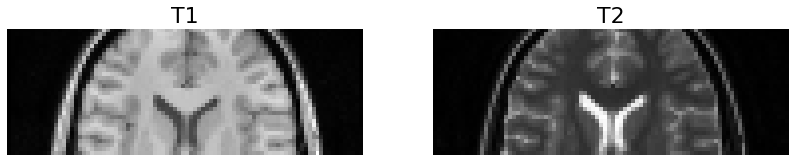

In [42]:
t1_crop, t2_crop = random_crop((img1, img2))
assert t1_crop.shape == t2_crop.shape and t1_crop.shape != 0
print(t1_crop.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=f_size)
ax1.imshow(t1_crop[0][:,15,:], cmap='gray')
ax1.set_title('T1', fontsize=22)
ax1.axis('off')

ax2.imshow(t2_crop[0][:,15,:], cmap='gray')
ax2.set_title('T2', fontsize=22)
ax2.axis('off');